# Generating catalogs with SkyCatalog

This is a demonstration of using the `SkyCatalog` class to generate catalogs of sky positions over parts of the sky

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd

In [2]:
# the jupyter kernel needs to be reset if changes are made to the class
%load_ext autoreload
%reload_ext autoreload
from catalog_class import SkyCatalogue

Initialize with minimum object masking radius (default = 20 arcsec), spacing between dark sky positions (default = 45 arsec), dimension of segmentation map analysis (default = 1 degree), and DR10 wavebands to use in addition to g (g, r, i, z)

In [3]:
# TODO: make it so you can select which bands to use?

catalog = SkyCatalogue()
ra = 3
dec = -4
# catalog_g_band = SkyCatalogue(bands=('g'))

Loading masked star data....
Defining grid lines...
Creating KDTree for distance calculations...
KDTree created!


Sky positions can be generated on multiple different levels:
- Single degree (1 x 1) squares using an externally provided dataframe of star ra/dec and mask radius to work from
- Single query (n x n degree) square split up into single-degree chunks
- "Full sky" split up into (n x n degree) square queries, with each of those also split into single-degree chunks

In [4]:
# single degree
# query LSDR10 catalog from NOIRLab Astro Data Lab
# query_df = catalog.query_tractor(ra, dec)
# single_degree_catalog, overlap = catalog.create_degree_square(ra, dec, query_df, plot_image=True)
# print(f"Positions found: {single_degree_catalog.size}")

Elapsed time: 8.2055 seconds
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
Elapsed time: 4.5958 seconds
>>>> Finding dark regions in segmentation map...
>>>> Plotting dark regions...


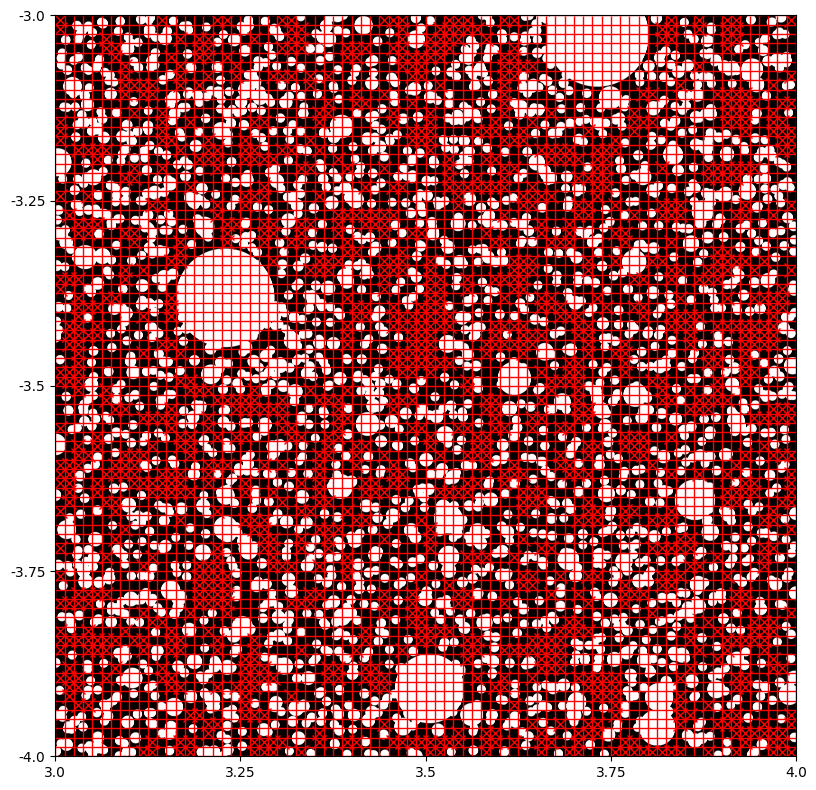

>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...
>>>> Done!


In [4]:
# single degree
# query LSDR10 catalog from NOIRLab Astro Data Lab
catalog.bands = ('g')
query_df = catalog.query_tractor(ra, dec)
single_degree_catalog, overlap = catalog.create_degree_square(ra, dec, query_df, plot_image=True)
# print(f"Positions found: {single_degree_catalog.size}")

In [6]:
# multiple degrees
# 2x2 degree query square with all bands (griz) = 73.34 s
# this finds 218 dark sky positions in that area
catalog.bands = ('g', 'r', 'i', 'z')
positions_allbands = catalog.create_catalogue(ra, dec, 2)

# 2x2 degree query square with just g band = 37.66 s
# this finds 9716 dark sky positions in that area
catalog.bands = ('g')
positions_gband = catalog.create_catalogue(ra, dec, 2)
catalog.bands = ('g', 'r')
positions_grbands = catalog.create_catalogue(ra, dec, 2)
catalog.bands = ('g', 'r', 'i')
positions_gribands = catalog.create_catalogue(ra, dec, 2)

> Creating sky catalog from one 2-degree square starting from (3, -4) to (5, -2)
>> Querying the tractor catalog for stars from RA/DEC(3, -4) to (5, -2)...
Elapsed time: 24.2531 seconds
>> Looping through sky coordinates...
>>> Generating sky catalog for square RA,DEC (3, -4) to (4, -3)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
Elapsed time: 5.6645 seconds
>>>> Finding dark regions in segmentation map...
>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...
>>>> Done!
>>> Generating sky catalog for square RA,DEC (4, -4) to (5, -3)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
Elapsed time: 4.8575 seconds
>>>> Finding dark regions in segmentation map...
>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...

Positions found (griz): 210
Positions found (gri): 670
Positions found (gr): 2304
Positions found (g): 9626


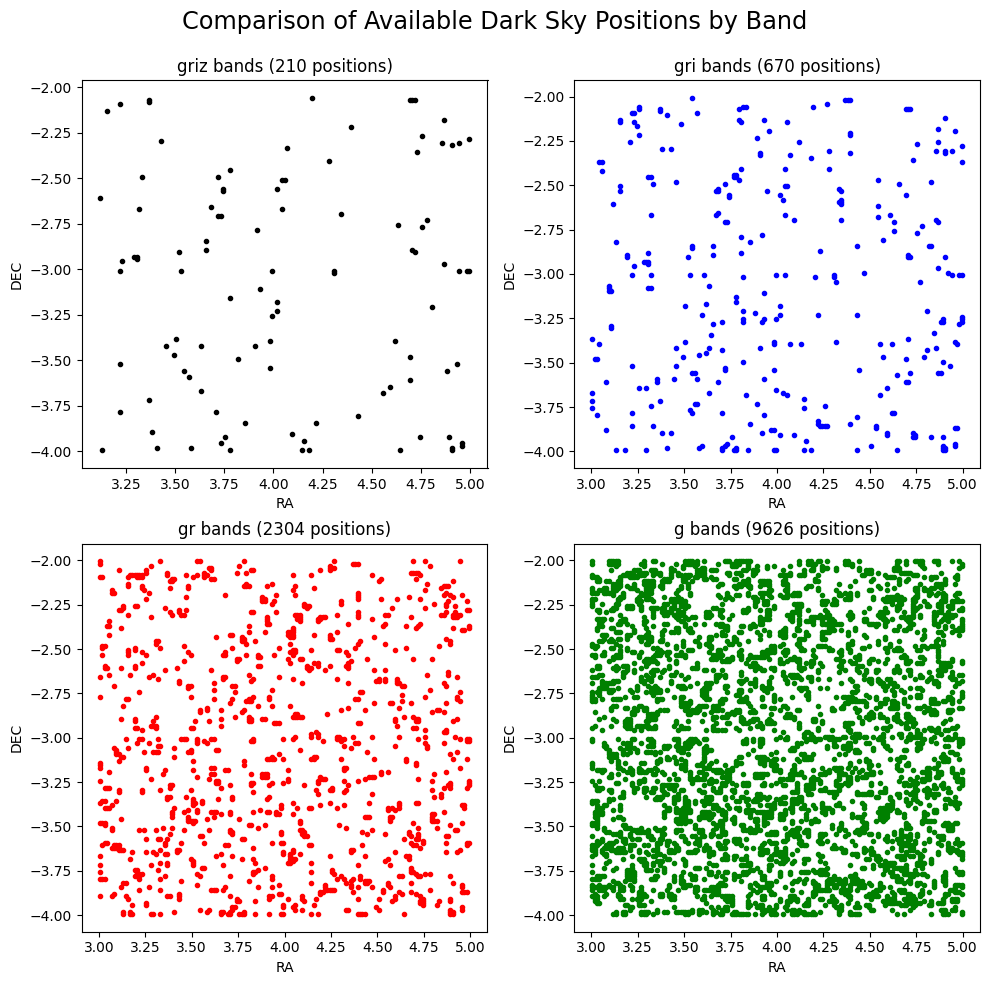

In [7]:
# difference between griz and g band in the same area
print(f"Positions found (griz): {positions_allbands.size}")
print(f"Positions found (gri): {positions_gribands.size}")
print(f"Positions found (gr): {positions_grbands.size}")
print(f"Positions found (g): {positions_gband.size}")

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].plot(positions_allbands['ra'], positions_allbands['dec'], 'k.')
ax[0,0].set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[0,1].plot(positions_gribands['ra'], positions_gribands['dec'], 'b.')
ax[0,1].set(title=f"gri bands ({positions_gribands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,0].plot(positions_grbands['ra'], positions_grbands['dec'], 'r.')
ax[1,0].set(title=f"gr bands ({positions_grbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,1].plot(positions_gband['ra'], positions_gband['dec'], 'g.')
ax[1,1].set(title=f"g bands ({positions_gband.size} positions)", xlabel="RA", ylabel="DEC")

fig.tight_layout()
fig.suptitle("Comparison of Available Dark Sky Positions by Band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)

plt.show()

In [8]:
# generate "whole sky"
# positions_allsky_gband = catalog_g_band.all_sky(query_dist=2.0)

# generate sections of the whole sky
# positions_allsky_gband = catalog.all_sky(query_dist=2.0, min_ra=212, max_ra=216, min_dec=16, max_dec=20, bands=('g', 'r', 'i', 'z'))

In [9]:
# fig, ax = plt.subplots()
# ax.plot(positions_allsky_gband['ra'], positions_allsky_gband['dec'], 'g.')
# ax.set(title=f"g bands ({positions_allsky_gband.size} positions)", xlabel="RA", ylabel="DEC")
# plt.tight_layout()
# plt.show()

Whole sky generation avoids the Galactic plane (within |b| > 18) and the LMC / SMC, and simply does not run the dark sky finding algorithms on the degree-level squares that intersect with those boundaries.

## Characterizing distances

In [10]:
from sklearn.neighbors import KDTree

# generate random list of (ra, dec) positions within the bounds of that square
random_ra = np.random.uniform(ra, ra+2, size=10000)
random_dec = np.random.uniform(dec, dec+2, size=10000)

# find closest point to that ra/dec pair
points = np.asarray([random_ra, random_dec]).T
griz_tree = KDTree(np.asarray([positions_allbands['ra'], positions_allbands['dec']]).T)
gri_tree = KDTree(np.asarray([positions_gribands['ra'], positions_gribands['dec']]).T)
gr_tree = KDTree(np.asarray([positions_grbands['ra'], positions_grbands['dec']]).T)
g_tree = KDTree(np.asarray([positions_gband['ra'], positions_gband['dec']]).T)

griz_dist, griz_nearest = griz_tree.query(points, 1, return_distance=True)
gri_dist, gri_nearest = gri_tree.query(points, 1, return_distance=True)
gr_dist, gr_nearest = gr_tree.query(points, 1, return_distance=True)
g_dist, g_nearest = g_tree.query(points, 1, return_distance=True)

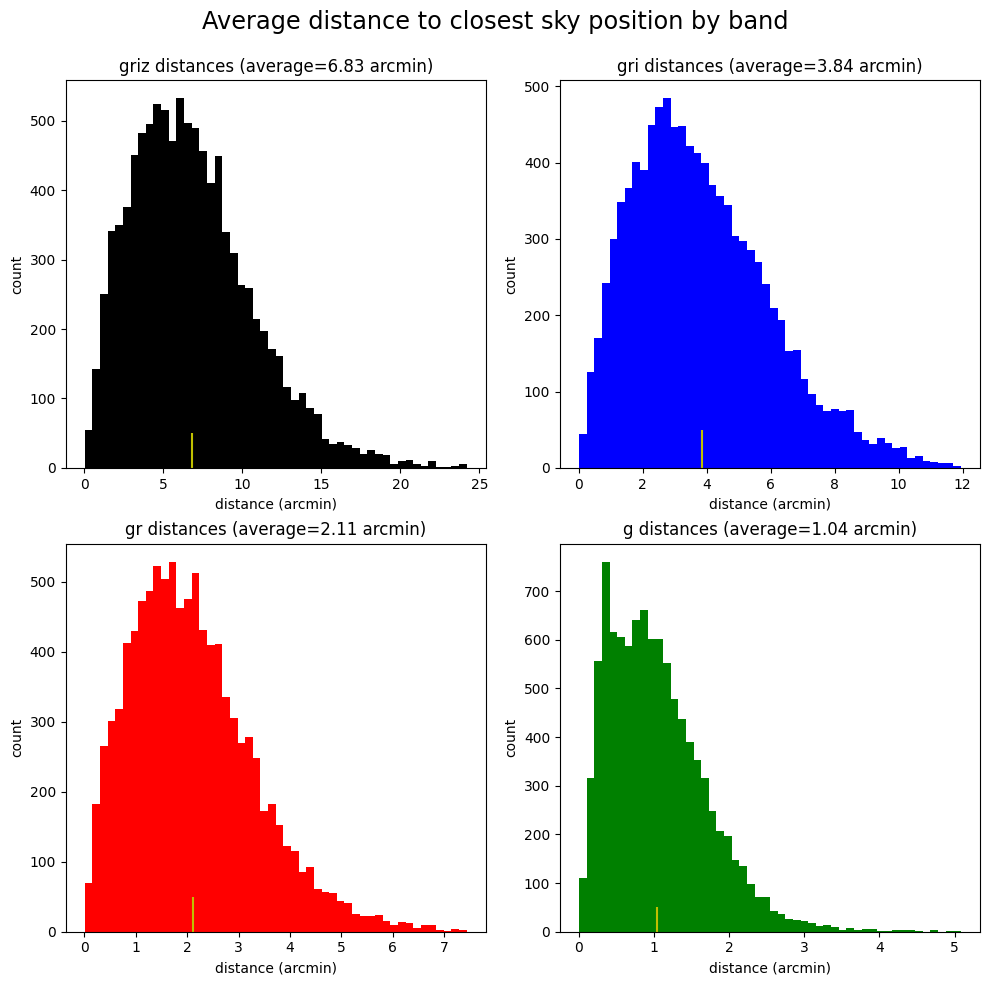

In [15]:
griz_avg = np.average(griz_dist)*60
gri_avg = np.average(gri_dist)*60
gr_avg = np.average(gr_dist)*60
g_avg = np.average(g_dist)*60


fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].hist(griz_dist*60, bins=50, color='k')
ax[0,0].vlines(griz_avg, ymin=0, ymax=50, color='y')
ax[0,0].set(title=f"griz distances (average={griz_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[0,1].hist(gri_dist*60, bins=50, color='b')
ax[0,1].vlines(gri_avg, ymin=0, ymax=50, color='y')
ax[0,1].set(title=f"gri distances (average={gri_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[1,0].hist(gr_dist*60, bins=50, color='r')
ax[1,0].vlines(gr_avg, ymin=0, ymax=50, color='y')
ax[1,0].set(title=f"gr distances (average={gr_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[1,1].hist(g_dist*60, bins=50, color='g')
ax[1,1].vlines(g_avg, ymin=0, ymax=50, color='y')
ax[1,1].set(title=f"g distances (average={g_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

fig.tight_layout()
fig.suptitle("Average distance to closest sky position by band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)
plt.show()

Positions found (griz): 210
Positions found (gri): 670
Positions found (gr): 2304
Positions found (g): 9626


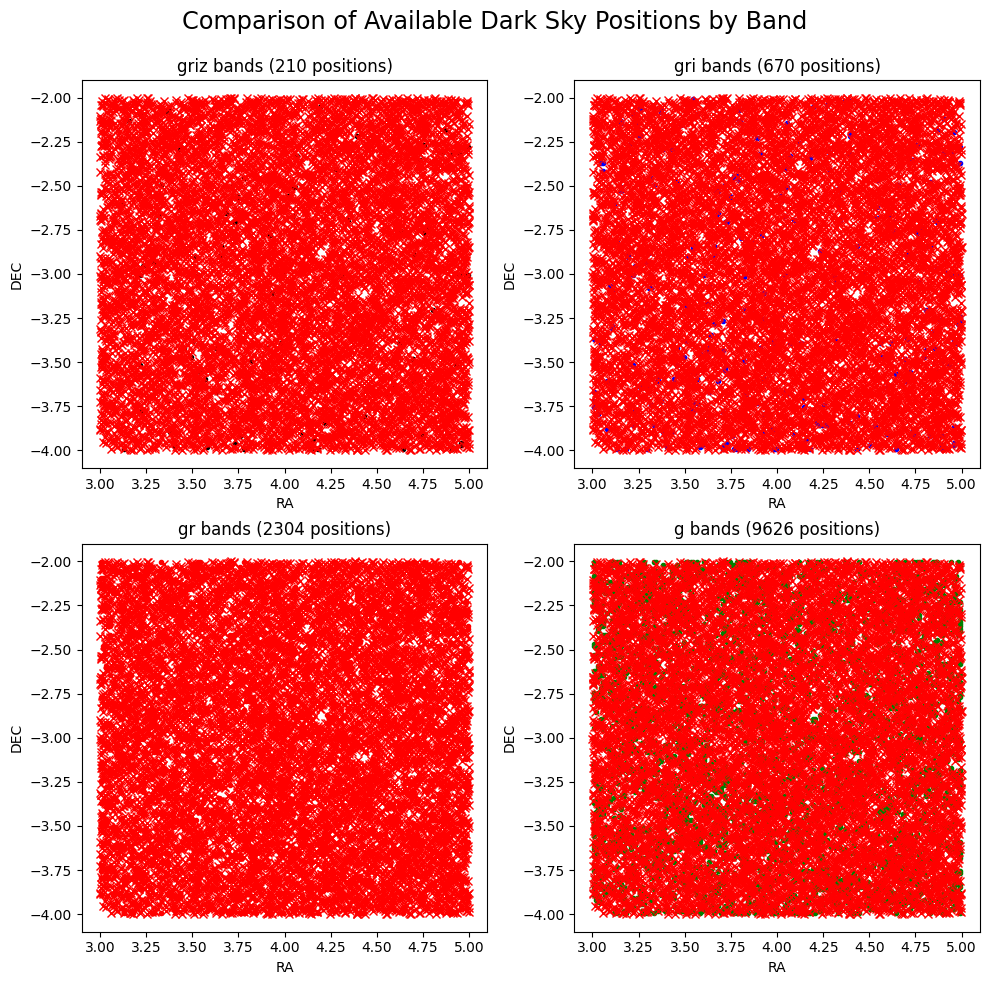

In [12]:
# difference between griz and g band in the same area
print(f"Positions found (griz): {positions_allbands.size}")
print(f"Positions found (gri): {positions_gribands.size}")
print(f"Positions found (gr): {positions_grbands.size}")
print(f"Positions found (g): {positions_gband.size}")

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].plot(positions_allbands['ra'], positions_allbands['dec'], 'k.')
ax[0,0].plot(random_ra, random_dec, 'rx')
ax[0,0].set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[0,1].plot(positions_gribands['ra'], positions_gribands['dec'], 'b.')
ax[0,1].plot(random_ra, random_dec, 'rx')
ax[0,1].set(title=f"gri bands ({positions_gribands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,0].plot(positions_grbands['ra'], positions_grbands['dec'], 'r.')
ax[1,0].plot(random_ra, random_dec, 'rx')
ax[1,0].set(title=f"gr bands ({positions_grbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,1].plot(positions_gband['ra'], positions_gband['dec'], 'g.')
ax[1,1].plot(random_ra, random_dec, 'rx')
ax[1,1].set(title=f"g bands ({positions_gband.size} positions)", xlabel="RA", ylabel="DEC")

fig.tight_layout()
fig.suptitle("Comparison of Available Dark Sky Positions by Band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)

plt.show()